# Dogs vs Cats Notebook

## By Pranav Tomar

We are going to solve the problem of Dogs-vs-Cats steps by steps

Step : 1
Importing Libraries

In [30]:
import numpy as np
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

Checking the downloaded data from : https://www.kaggle.com/c/dogs-vs-cats/data?select=test1.zip

In [31]:
print(os.listdir("/Users/pranavtomar/Downloads/dogs-vs-cats"))

['.DS_Store', 'sampleSubmission.csv', 'test1', 'test1.zip', 'train', 'train.zip']


Step 2: Defining Constants we are going to use

In [32]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

Step 3: Preparing training data from images, as .jpg saved with name dog are pictures of dog and files named cat are cats picture.
Using this information to create a category data, where cats are '0' and dogs are '1'

In [33]:
filenames = os.listdir("/Users/pranavtomar/Downloads/dogs-vs-cats/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [34]:
df.head()

,filename,category
0,dog.8011.jpg,1
1,cat.5077.jpg,0
2,dog.7322.jpg,1
3,cat.2718.jpg,0
4,cat.10151.jpg,0


In [35]:
df.tail()

,filename,category
24995,dog.8008.jpg,1
24996,dog.1992.jpg,1
24997,dog.12412.jpg,1
24998,cat.2701.jpg,0
24999,cat.10148.jpg,0


Step 4: Checking the number of data for both the catergories

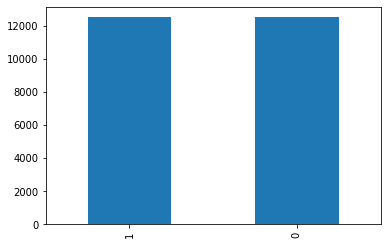

In [36]:
df['category'].value_counts().plot.bar()

Step 5: Sample image

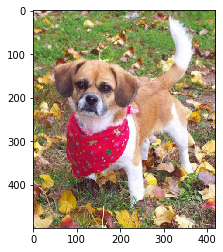

In [37]:
sample = random.choice(filenames)
image = load_img("/Users/pranavtomar/Downloads/dogs-vs-cats/train/"+sample)
plt.imshow(image)

## Building Model

In [38]:
import tensorflow as tf

In [39]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

In [40]:
model = Sequential()

#layer 1 (Feature Extraction)
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#layer 2 (Feature Extraction)
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#layer 3 (Feature Extraction)
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#layer 4 (Fully Connected Layer : Classifier)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer= 'rmsprop', metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)       

Step 7: Adding Callbacks

In [41]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [42]:
#EarlyStopping

earlystop = EarlyStopping(patience = 10)

In [43]:
#Learning Rate Reduction

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience = 2,
                                           verbose= 1,
                                           factor=0.5,
                                           min_lr=0.00001)

In [44]:
callbacks = [earlystop, learning_rate_reduction]

Step 8: Preparing Data for Operation

As we are using image generator with class_mode = 'categorical'. We need to convert column category into string.

In [45]:
df['category'] = df['category'].replace({0: 'cat', 1: 'dog'})

In [46]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

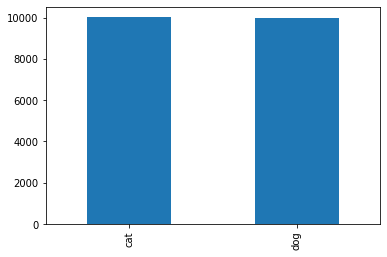

In [47]:
train_df['category'].value_counts().plot.bar()

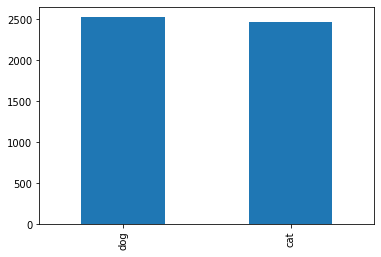

In [48]:
validate_df['category'].value_counts().plot.bar()

In [49]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15


## training generator

In [50]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/Users/pranavtomar/Downloads/dogs-vs-cats/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


## Validation generator

In [51]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/Users/pranavtomar/Downloads/dogs-vs-cats/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [52]:
#Checking how our image generator works
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/Users/pranavtomar/Downloads/dogs-vs-cats/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


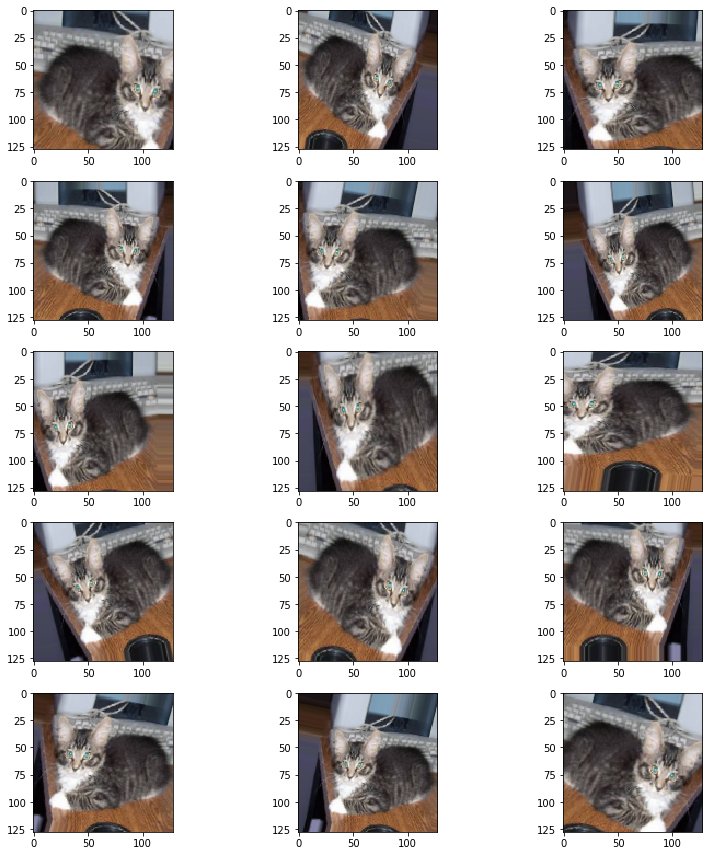

In [53]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Fit Model

In [54]:
epochs=3
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/3
1333/1333 [==============================] - 454s 341ms/step - loss: 0.7449 - accuracy: 0.6349 - val_loss: 0.6070 - val_accuracy: 0.6953 - lr: 0.0010
Epoch 2/3
1333/1333 [==============================] - 473s 354ms/step - loss: 0.5677 - accuracy: 0.7152 - val_loss: 0.6117 - val_accuracy: 0.7065 - lr: 0.0010
Epoch 3/3
1333/1333 [==============================] - 460s 345ms/step - loss: 0.5131 - accuracy: 0.7530 - val_loss: 0.5428 - val_accuracy: 0.7375 - lr: 0.0010


In [57]:
model.save('model_with_3_epochs.hdf5')

In [58]:
model.save_weights('model_with_3_epochs.h5')

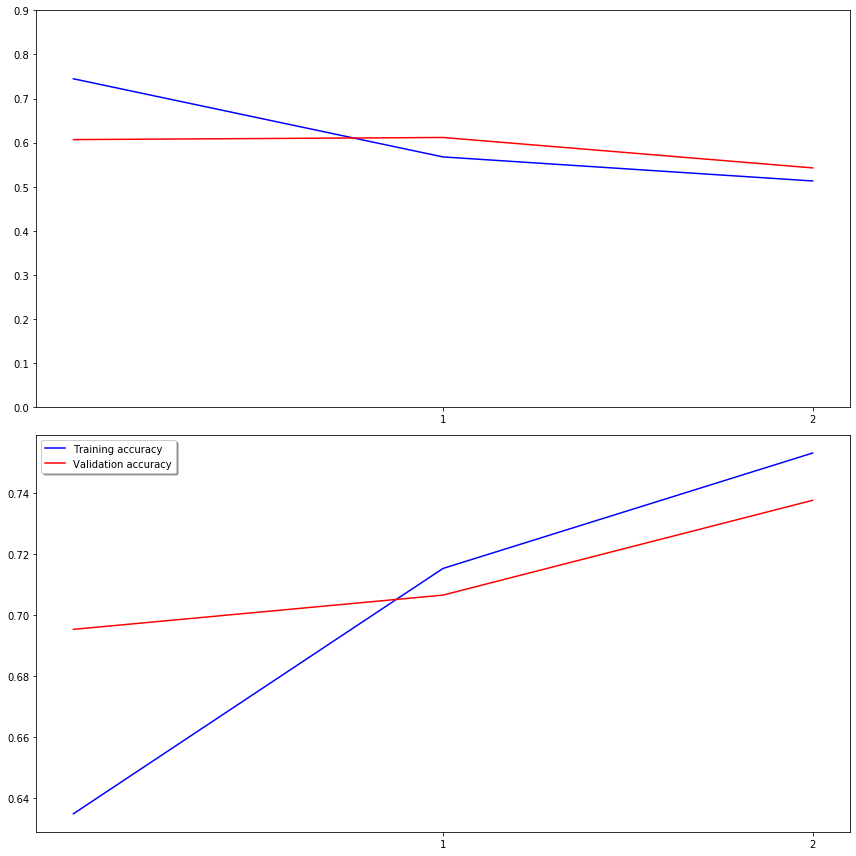

In [64]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()


# Imorting and Preparing data for tesing

In [65]:
test_filenames = os.listdir("/Users/pranavtomar/Downloads/dogs-vs-cats/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [66]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/Users/pranavtomar/Downloads/dogs-vs-cats/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


# Predict

In [67]:
predict = model.predict(test_generator, steps = np.ceil(nb_samples/batch_size))

In [68]:
test_df['category'] = np.argmax(predict, axis=-1)

In [69]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [70]:
test_df['category'] = test_df['category'].replace({'dog' : 1, 'cat': 0})

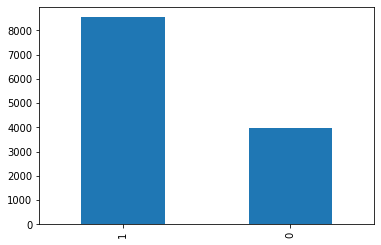

In [71]:
#visualize result
test_df['category'].value_counts().plot.bar()

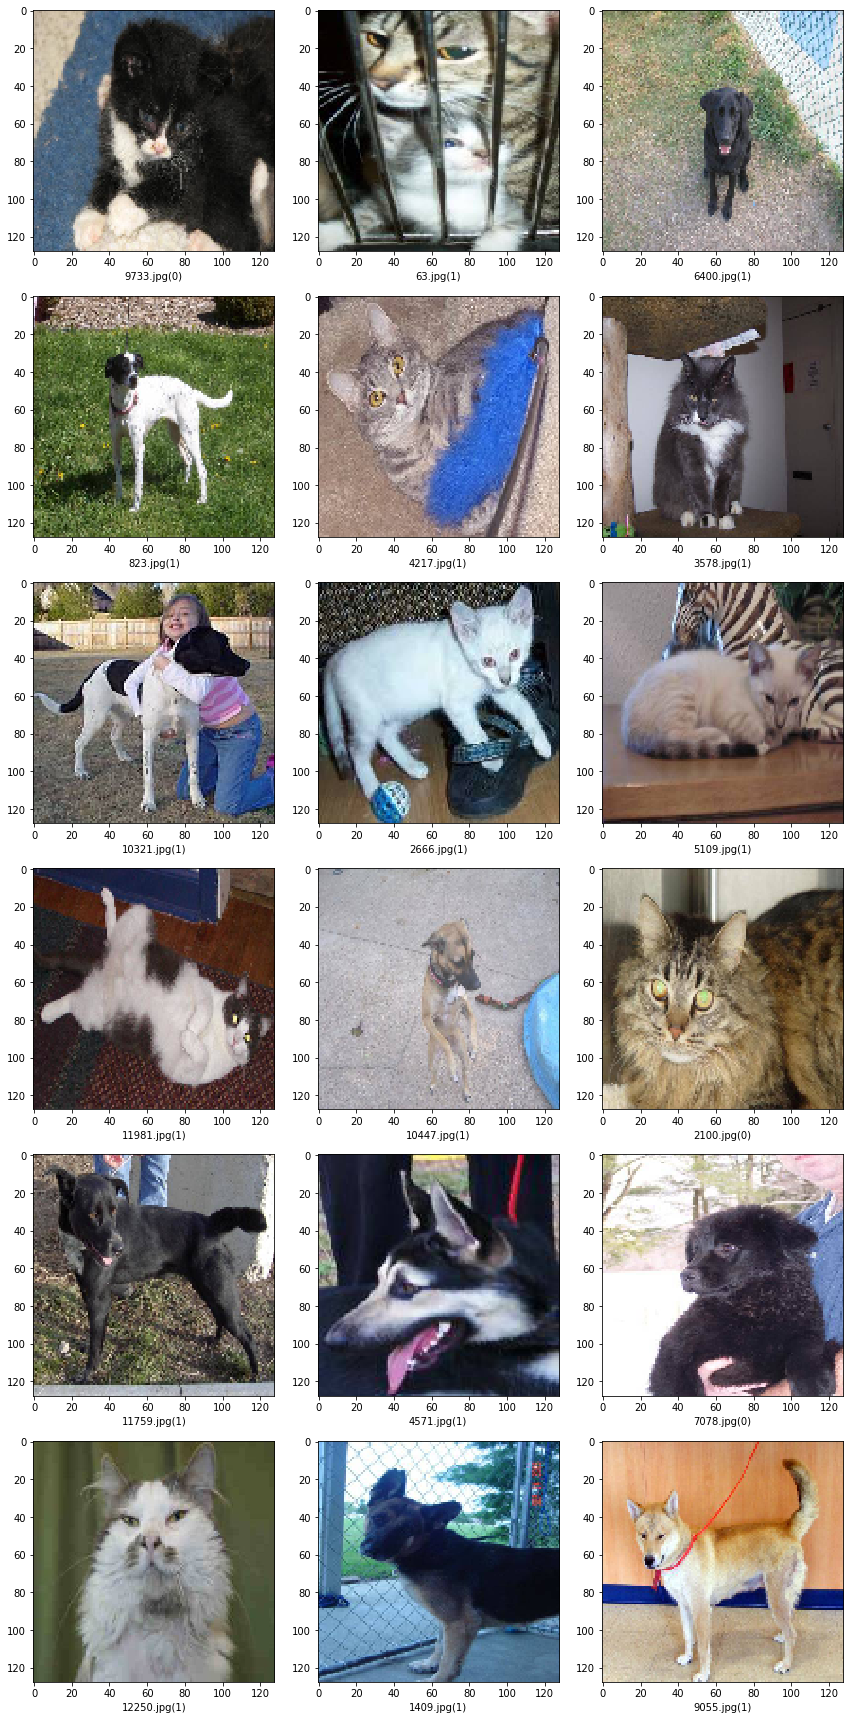

In [72]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/Users/pranavtomar/Downloads/dogs-vs-cats/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [73]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)

# Testing on randomly picked pictures from google